# 1. Import Libraries:

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Load Dataset:

In [2]:
df = pd.read_csv("/kaggle/input/resume-vs-job-description-matching-dataset/resume_job_matching_dataset.csv") 

df.head(10)

,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5
5,"Data Analyst needed with experience in Excel, ...",Experienced professional skilled in Data Clean...,2
6,Software Engineer needed with experience in RE...,Experienced professional skilled in System Des...,2
7,Product Manager needed with experience in Stak...,Experienced professional skilled in Product Ro...,3
8,"Data Analyst needed with experience in Excel, ...","Experienced professional skilled in as, choice...",4
9,"ML Engineer needed with experience in MLOps, P...","Experienced professional skilled in author, Co...",2


- The dataset resume_job_matching_dataset.csv includes job descriptions, resumes, and a match_score (1–5) indicating alignment between them, with higher scores reflecting stronger matches.

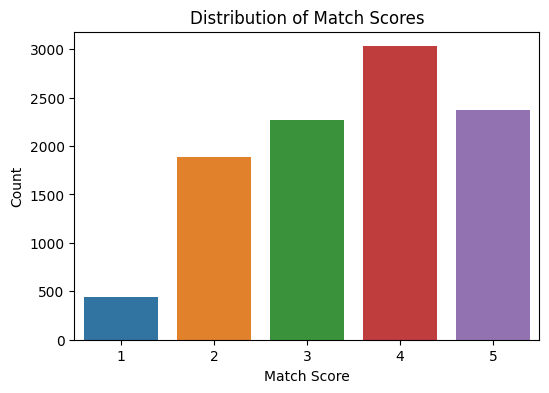

In [3]:

# Distribution of match scores
plt.figure(figsize=(6,4))
sns.countplot(x="match_score", data=df)
plt.title("Distribution of Match Scores")
plt.xlabel("Match Score")
plt.ylabel("Count")
plt.show()


# 3. Data Cleaning:

In [4]:
# clean all missing values if there is any 
df = df.dropna(subset=["job_description", "resume"])
df = df.reset_index(drop=True)

print("Dataset size:", df.shape)


Dataset size: (10000, 3)


# 4. TF-IDF Vectorisation:

In [5]:
# Combine job descriptions and resumes into one corpus
corpus = df["job_description"].tolist() + df["resume"].tolist()

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(corpus)

# Split vectors (job + resume)
n = len(df)
job_vecs = X[:n]
resume_vecs = X[n:]


# 5.Cosine Similarity:

In [6]:
# Compute similarity for each job–resume pair
df["predicted_similarity"] = [
    cosine_similarity(job_vecs[i], resume_vecs[i])[0][0] for i in range(n)
]

df.head()


,job_description,resume,match_score,predicted_similarity
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4,0.106714
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4,0.149304
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5,0.108091
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4,0.117521
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5,0.186584


# 6. Evaluation:

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range=(1, 5))

# Scale predicted similarities to match the 1–5 range
df["predicted_scaled"] = scaler.fit_transform(df[["predicted_similarity"]])

# Compute Mean Squared Error
mse = mean_squared_error(df["match_score"], df["predicted_scaled"])
print("MSE:", mse)



MSE: 2.9681902289012396


In [8]:
# Create a comparison table
comparison_df = df[["job_description", "resume", "match_score", "predicted_scaled"]]

comparison_df.head(10)


,job_description,resume,match_score,predicted_scaled
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4,2.055367
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4,2.476568
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5,2.068986
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4,2.162245
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5,2.845256
5,"Data Analyst needed with experience in Excel, ...",Experienced professional skilled in Data Clean...,2,2.024175
6,Software Engineer needed with experience in RE...,Experienced professional skilled in System Des...,2,2.815928
7,Product Manager needed with experience in Stak...,Experienced professional skilled in Product Ro...,3,2.047768
8,"Data Analyst needed with experience in Excel, ...","Experienced professional skilled in as, choice...",4,2.199907
9,"ML Engineer needed with experience in MLOps, P...","Experienced professional skilled in author, Co...",2,1.139395


# 7. Visualisation:

## 7.1 Compute Resume Similarity for One Job

In [9]:
job_text = df.loc[0, "job_description"]

# Compare against ALL resumes
job_vec = vectorizer.transform([job_text])
similarities = cosine_similarity(job_vec, resume_vecs).flatten()

# Store ranking
ranking = df.copy()
ranking["similarity_score"] = similarities
ranking = ranking.sort_values(by="similarity_score", ascending=False)

ranking[["resume", "similarity_score"]].head(5)


,resume,similarity_score
9261,"Experienced professional skilled in Power BI, ...",0.387788
8202,"Experienced professional skilled in Reporting,...",0.360314
2824,"Experienced professional skilled in Power BI, ...",0.328135
2206,"Experienced professional skilled in Excel, Pow...",0.327663
2296,"Experienced professional skilled in value, Exc...",0.316530


The top 5 candidates for this job show similarity scores ranging from 38.77% (strongest match) to 31.65% (weaker but still relevant), suggesting a moderate overlap between their resumes and the job description.

## 7.2 Top Resume Matches:

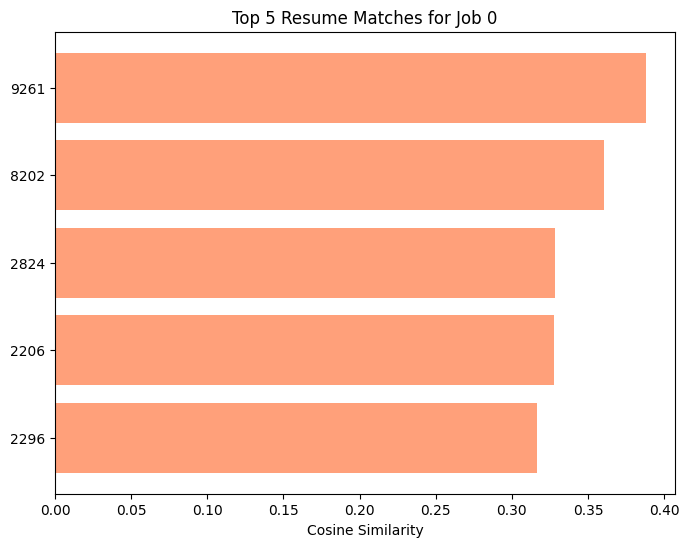

In [10]:
top5 = ranking.head(5)

plt.figure(figsize=(8,6))
plt.barh(top5.index.astype(str), top5["similarity_score"], color="lightsalmon")
plt.gca().invert_yaxis()
plt.title("Top 5 Resume Matches for Job 0")
plt.xlabel("Cosine Similarity")
plt.show()


- The chart shows that candidate 9261 is the best match for the first job description which index 0 , it have similarity rate of 39%, followed by 8202 and 2824 and 2206 and 2296. 

## 7.3 Detailed Candidate Report:

In [11]:

ranking["candidate_id"] = ranking.index
top5 = ranking.head(5)

# Define job info
job_id = 0
job_title = " ".join(job_text.split()[:2])
job_text = df.loc[job_id, "job_description"]

# Print job info
print(f"\nJob {job_id} Title: {job_title}")
print(f"Job {job_id} Description:\n{job_text[:50]}...\n")

# Print top 5 candidates
print("Top 5 Candidates:")
for idx, row in top5.iterrows():
    print("=" * 80)
    print(f"Candidate ID     : {row['candidate_id']}")
    print(f"Similarity Score : {row['similarity_score']:.4f}")
    print(f"Resume           : {row['resume'][:50]}...\n")



Job 0 Title: Data Analyst
Job 0 Description:
Data Analyst needed with experience in SQL, Excel,...

Top 5 Candidates:
Candidate ID     : 9261
Similarity Score : 0.3878
Resume           : Experienced professional skilled in Power BI, Tabl...

Candidate ID     : 8202
Similarity Score : 0.3603
Resume           : Experienced professional skilled in Reporting, SQL...

Candidate ID     : 2824
Similarity Score : 0.3281
Resume           : Experienced professional skilled in Power BI, retu...

Candidate ID     : 2206
Similarity Score : 0.3277
Resume           : Experienced professional skilled in Excel, Power B...

Candidate ID     : 2296
Similarity Score : 0.3165
Resume           : Experienced professional skilled in value, Excel, ...

